Importing libraries

In [259]:
import os
import seaborn as sns 
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
from sklearn import ensemble, model_selection, metrics 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split , cross_val_score , RandomizedSearchCV
import xgboost as xgb

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [260]:
df_test=pd.read_csv('/Users/olegmonahov/Downloads/test_lAUu6dG.csv')
df_train=pd.read_csv('/Users/olegmonahov/Downloads/train_ctrUa4K.csv')

<b>Exploratory Data analysis </b> <br>
At this stage, I'm visualizing different features to understand what might be a driver of application approvals

In [261]:
df_train.shape

(614, 13)

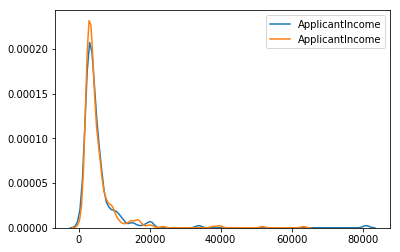

In [262]:
fig, ax = plt.subplots()

sns.kdeplot(df_train[df_train['Loan_Status']=='N']['ApplicantIncome'], ax=ax)
sns.kdeplot(df_train[df_train['Loan_Status']=='Y']['ApplicantIncome'], ax=ax)

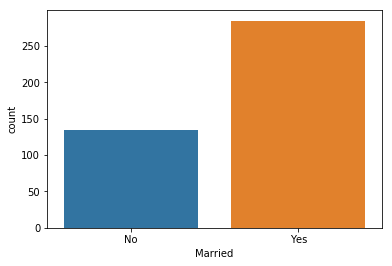

In [263]:
sns.countplot(df_train[df_train['Loan_Status']=='Y']['Married'])

At this stage I'm trying to check correlation of each feature with each other to understand what might be driving 

In [354]:
data1.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


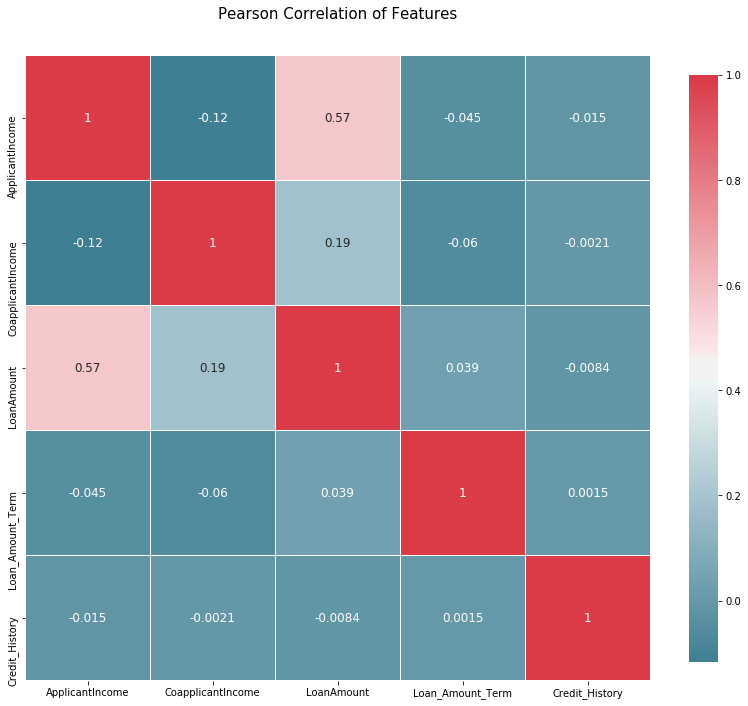

In [264]:

correlation_heatmap(data1)

The issue that a lot of data is Object formats and as the model can work wiht numerical data only, we need to translate it to int formats

<h3>Dealing with categorical data </h3>

In [265]:
#In order to approach the problem of categorical data, we'll create a stand alone data frame to deal with objects
obj_df = df_train.select_dtypes(include=['object']).copy()


In [266]:
obj_df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

Also we need to decide how to deal with missing data. In this case, I'll be just replacing it with the most common values

In [267]:
# e.g. changing all the missing values of gender because self employed is the most common option 

obj_df = obj_df.fillna({"Self_Employed": "No"})


In [268]:
obj_df['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [269]:
obj_df = obj_df.fillna({"Gender": "Male"})


In [270]:
obj_df['Dependents'].value_counts()
obj_df = obj_df.fillna({"Dependents": "0"})


In [271]:
obj_df['Married'].value_counts()
obj_df = obj_df.fillna({"Married": "0"})


In [272]:
# checking shape of a new object dataframe
obj_df.shape

(614, 8)

In this section I'm using .cat.codes to translate Object data to int

In [273]:
obj_df["Gender"] = obj_df["Gender"].astype('category')

obj_df["Gender"] = obj_df["Gender"].cat.codes

In [274]:

obj_df["Married"] = obj_df["Married"].astype('category')

obj_df["Married"] = obj_df["Married"].cat.codes

In [275]:

obj_df["Dependents"] = obj_df["Dependents"].astype('category')

obj_df["Dependents"] = obj_df["Dependents"].cat.codes


In [276]:

obj_df["Education"] = obj_df["Education"].astype('category')

obj_df["Education"] = obj_df["Education"].cat.codes


In [277]:

obj_df["Self_Employed"] = obj_df["Self_Employed"].astype('category')

obj_df["Self_Employed"] = obj_df["Self_Employed"].cat.codes


In [278]:

obj_df["Property_Area"] = obj_df["Property_Area"].astype('category')

obj_df["Property_Area"] = obj_df["Property_Area"].cat.codes


In [279]:

obj_df["Loan_Status"] = obj_df["Loan_Status"].astype('category')

obj_df["Loan_Status"] = obj_df["Loan_Status"].cat.codes


Lets look at the resulting dataframe 

In [280]:
obj_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,1,1,0,0,0,2,1
1,LP001003,1,2,1,0,0,0,0
2,LP001005,1,2,0,0,1,2,1
3,LP001006,1,2,0,1,0,2,1
4,LP001008,1,1,0,0,0,2,1


In [281]:
obj_df.dtypes

Loan_ID          object
Gender             int8
Married            int8
Dependents         int8
Education          int8
Self_Employed      int8
Property_Area      int8
Loan_Status        int8
dtype: object

In [282]:
obj_df.shape

(614, 8)

So we achieved what was intended - getting all the categorical data as numerical values, dealing with NaNs succesfully 

<h3>Cleaning numerical data </h3>
At this stage we need to deal with missing values for numerical part of a dataset. For this let's build a stand alone DF with numerical data only

In [283]:
int_df = df_train.select_dtypes(include=['int','float64']).copy()
int_df = int_df.fillna({"LoanAmount": np.mean(int_df['LoanAmount'])})
int_df = int_df.fillna({"Loan_Amount_Term": np.mean(int_df['Loan_Amount_Term'])})
int_df = int_df.fillna({"Credit_History": 1})

In [284]:
int_df.shape

(614, 5)

Let's try to concatenate both numerical and object part of data set to get the resulting dataframe 

In [355]:
result = pd.concat([int_df, obj_df], axis=1, join='inner')
result.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,5849,0.0,146.412162,360.0,1.0,LP001002,1,1,0,0,0,2,1
1,4583,1508.0,128.000000,360.0,1.0,LP001003,1,2,1,0,0,0,0
2,3000,0.0,66.000000,360.0,1.0,LP001005,1,2,0,0,1,2,1
3,2583,2358.0,120.000000,360.0,1.0,LP001006,1,2,0,1,0,2,1
4,6000,0.0,141.000000,360.0,1.0,LP001008,1,1,0,0,0,2,1


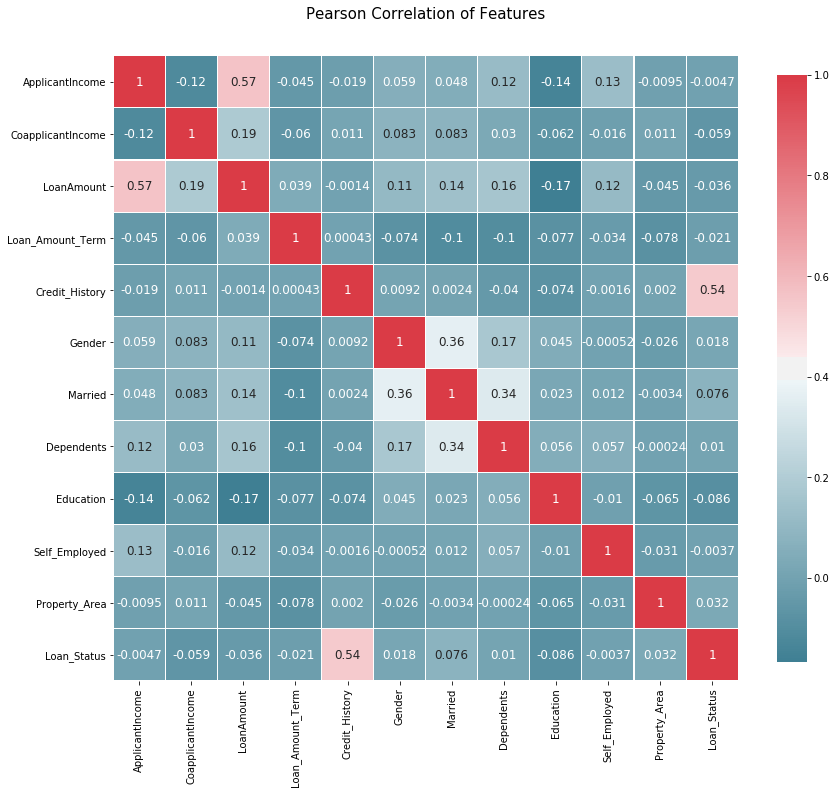

In [287]:

correlation_heatmap(result)

Dealing with outliers? 

It might be beneficial to get rid of outliers as they might be affecting results


In [288]:
result.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.000000,0.855049,0.817590,1.643322,0.744300,0.218241,0.133550,1.037459,0.687296
std,6109.041673,2926.248369,84.037468,64.372489,0.352339,0.386497,0.489511,1.009623,0.413389,0.340446,0.787482,0.463973
min,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000,1.000000


In [289]:
result=result[result['ApplicantIncome']<34000]
result=result[result['CoapplicantIncome']<25300]

In [290]:
result.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,4954.632013,1510.216040,143.622224,342.752475,0.856436,0.816832,1.643564,0.732673,0.221122,0.133663,1.033003,0.688119
std,3662.995693,2063.919373,77.173600,63.740498,0.350937,0.387124,0.489577,0.998092,0.415345,0.340571,0.787653,0.463644
min,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3787.500000,1211.500000,128.000000,360.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,5721.500000,2281.000000,162.000000,360.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000
max,33846.000000,20000.000000,650.000000,480.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000,1.000000


<h3>Dealing with multicollinearity</h3>

In [291]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [292]:
result.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_ID', 'Gender', 'Married',
       'Dependents', 'Education', 'Self_Employed', 'Property_Area',
       'Loan_Status'],
      dtype='object')

In [293]:
Z=result[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
        'Credit_History', 'Gender', 'Married',
       'Dependents', 'Education', 'Self_Employed', 'Property_Area']]

In [295]:
sum(calc_vif(Z)['VIF'])

62.2652168282312

In [296]:
calc_vif(Z)

,variables,VIF
0,ApplicantIncome,5.335268
1,CoapplicantIncome,2.036299
2,LoanAmount,8.810068
3,Loan_Amount_Term,12.910838
4,Credit_History,6.318891
5,Gender,6.314228
6,Married,13.594508
7,Dependents,1.800953
8,Education,1.324140
9,Self_Employed,1.217399


In [297]:
calc_vif(result[['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term',
        'Credit_History', 'Gender', 'Married',
       'Dependents', 'Education', 'Self_Employed', 'Property_Area']])

,variables,VIF
0,ApplicantIncome,3.122441
1,CoapplicantIncome,1.693911
2,Loan_Amount_Term,12.191558
3,Credit_History,6.318013
4,Gender,6.312239
5,Married,13.532667
6,Dependents,1.788881
7,Education,1.321166
8,Self_Employed,1.217265
9,Property_Area,2.597477


In [298]:
result=result.sort_values(by='Loan_ID')
y = result['Loan_Status']

In [299]:
df_x=result[['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term',
        'Credit_History', 'Gender', 'Married',
       'Dependents', 'Education', 'Self_Employed', 'Property_Area']]

<h3>Normalizing values in training set </h3>
Obviously data is coming with in a very different numerical ranges. In the next step I'll be scaling those different values

In [311]:
x = df_x.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)


In [312]:
x.shape

(606, 10)

<h2>Random forest</h2>
<br>
I'll try to use Random forest as estimator for this excercise. I've approached to ML algo selection in a separate excercise and decided that RF is good enough. I'll spend more time on trying to understand what are the best parameters for selection 

In [136]:
estimator = ensemble.RandomForestClassifier()
rf=estimator.fit(x_scaled,y)

We have a task of selecting best possible parameters for the algorythm. I'll use the method RandomizedSearchCV for trying to find the best parameters out of those in range of rf_param

In [138]:
rf_param = {'n_estimators':list(range(5,270)) , 
         'min_samples_leaf':list(range(2,30)) , 
         'criterion':['gini','entropy'] ,
         'max_depth':list(range(1,40)),
            'min_samples_split':list(range(2,70))
}
rscv = RandomizedSearchCV(rf,
                          param_distributions=rf_param , 
                          cv =10 , n_iter=10 , scoring = 'accuracy',n_jobs =-1 , verbose =10)

In [140]:
rscv.fit(x_scaled,y);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy 
[CV] n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy 
[CV] n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy 
[CV] n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy 
[CV]  n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy, score=0.7868852459016393, total=   0.3s
[CV]  n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy, score=0.7868852459016393, total=   0.3s
[CV] n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy 
[CV]  n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy, score=0.819672131147541, total=   0.3s
[CV] n_estimators=59, min_samples_split

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s


[CV]  n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy, score=0.864406779661017, total=   0.3s
[CV] n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini 
[CV]  n_estimators=59, min_samples_split=15, min_samples_leaf=23, max_depth=5, criterion=entropy, score=0.8, total=   0.3s
[CV] n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s


[CV]  n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini, score=0.8032786885245902, total=   0.9s
[CV] n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini 
[CV]  n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini, score=0.819672131147541, total=   0.8s
[CV] n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini 
[CV]  n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini, score=0.7868852459016393, total=   0.8s
[CV] n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini 
[CV]  n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini, score=0.7868852459016393, total=   0.8s
[CV] n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini 
[CV]  n_estimators=161, min_samples_split=16, min_samples_leaf=15, ma

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s


[CV]  n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini, score=0.864406779661017, total=   0.9s
[CV] n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini 
[CV]  n_estimators=161, min_samples_split=16, min_samples_leaf=15, max_depth=16, criterion=gini, score=0.8, total=   1.0s
[CV] n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini 
[CV]  n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini, score=0.8032786885245902, total=   1.3s
[CV] n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini 
[CV]  n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini, score=0.819672131147541, total=   1.3s
[CV] n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini 
[CV]  n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, crit

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s


[CV]  n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini, score=0.7704918032786885, total=   1.4s
[CV] n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini 
[CV]  n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini, score=0.7868852459016393, total=   1.4s
[CV] n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini 
[CV]  n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini, score=0.8688524590163934, total=   1.4s
[CV] n_estimators=61, min_samples_split=57, min_samples_leaf=7, max_depth=34, criterion=entropy 
[CV]  n_estimators=258, min_samples_split=15, min_samples_leaf=16, max_depth=14, criterion=gini, score=0.8333333333333334, total=   1.4s
[CV] n_estimators=61, min_samples_split=57, min_samples_leaf=7, max_depth=34, criterion=entropy 
[CV]  n_estimators=61, min_samples_split=57, min_samples_leaf=7, m

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


[CV]  n_estimators=61, min_samples_split=57, min_samples_leaf=7, max_depth=34, criterion=entropy, score=0.7704918032786885, total=   0.4s
[CV]  n_estimators=61, min_samples_split=57, min_samples_leaf=7, max_depth=34, criterion=entropy, score=0.7868852459016393, total=   0.4s
[CV] n_estimators=61, min_samples_split=57, min_samples_leaf=7, max_depth=34, criterion=entropy 
[CV] n_estimators=61, min_samples_split=57, min_samples_leaf=7, max_depth=34, criterion=entropy 
[CV]  n_estimators=61, min_samples_split=57, min_samples_leaf=7, max_depth=34, criterion=entropy, score=0.8688524590163934, total=   0.4s
[CV] n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini 
[CV]  n_estimators=61, min_samples_split=57, min_samples_leaf=7, max_depth=34, criterion=entropy, score=0.8333333333333334, total=   0.4s
[CV] n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini 
[CV]  n_estimators=61, min_samples_split=57, min_samples_leaf=

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s


[CV] n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini 
[CV]  n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini, score=0.7868852459016393, total=   1.4s
[CV] n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini 
[CV]  n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini, score=0.7704918032786885, total=   1.1s
[CV] n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini 
[CV]  n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini, score=0.7868852459016393, total=   1.1s
[CV] n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini 
[CV]  n_estimators=251, min_samples_split=37, min_samples_leaf=25, max_depth=35, criterion=gini, score=0.8688524590163934, total=   1.1s
[CV] n_estimators=137, min_samples_split=17, min_samples_leaf=29, ma

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.7s


[CV]  n_estimators=137, min_samples_split=17, min_samples_leaf=29, max_depth=31, criterion=entropy, score=0.7704918032786885, total=   0.9s
[CV] n_estimators=137, min_samples_split=17, min_samples_leaf=29, max_depth=31, criterion=entropy 
[CV]  n_estimators=137, min_samples_split=17, min_samples_leaf=29, max_depth=31, criterion=entropy, score=0.7868852459016393, total=   0.9s
[CV] n_estimators=137, min_samples_split=17, min_samples_leaf=29, max_depth=31, criterion=entropy 
[CV]  n_estimators=137, min_samples_split=17, min_samples_leaf=29, max_depth=31, criterion=entropy, score=0.8688524590163934, total=   0.8s
[CV] n_estimators=188, min_samples_split=31, min_samples_leaf=21, max_depth=22, criterion=entropy 
[CV]  n_estimators=137, min_samples_split=17, min_samples_leaf=29, max_depth=31, criterion=entropy, score=0.8333333333333334, total=   0.8s
[CV] n_estimators=188, min_samples_split=31, min_samples_leaf=21, max_depth=22, criterion=entropy 
[CV]  n_estimators=137, min_samples_split=17

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.3s


[CV]  n_estimators=188, min_samples_split=31, min_samples_leaf=21, max_depth=22, criterion=entropy, score=0.7704918032786885, total=   1.6s
[CV] n_estimators=188, min_samples_split=31, min_samples_leaf=21, max_depth=22, criterion=entropy 
[CV]  n_estimators=188, min_samples_split=31, min_samples_leaf=21, max_depth=22, criterion=entropy, score=0.7868852459016393, total=   1.7s
[CV] n_estimators=188, min_samples_split=31, min_samples_leaf=21, max_depth=22, criterion=entropy 
[CV]  n_estimators=188, min_samples_split=31, min_samples_leaf=21, max_depth=22, criterion=entropy, score=0.8688524590163934, total=   1.8s
[CV] n_estimators=88, min_samples_split=66, min_samples_leaf=8, max_depth=20, criterion=entropy 
[CV]  n_estimators=188, min_samples_split=31, min_samples_leaf=21, max_depth=22, criterion=entropy, score=0.8333333333333334, total=   1.9s
[CV] n_estimators=88, min_samples_split=66, min_samples_leaf=8, max_depth=20, criterion=entropy 
[CV]  n_estimators=88, min_samples_split=66, min

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.3s


[CV]  n_estimators=23, min_samples_split=30, min_samples_leaf=11, max_depth=14, criterion=entropy, score=0.8032786885245902, total=   0.2s
[CV] n_estimators=23, min_samples_split=30, min_samples_leaf=11, max_depth=14, criterion=entropy 
[CV]  n_estimators=23, min_samples_split=30, min_samples_leaf=11, max_depth=14, criterion=entropy, score=0.819672131147541, total=   0.2s
[CV] n_estimators=23, min_samples_split=30, min_samples_leaf=11, max_depth=14, criterion=entropy 
[CV]  n_estimators=23, min_samples_split=30, min_samples_leaf=11, max_depth=14, criterion=entropy, score=0.7868852459016393, total=   0.2s
[CV] n_estimators=23, min_samples_split=30, min_samples_leaf=11, max_depth=14, criterion=entropy 
[CV]  n_estimators=88, min_samples_split=66, min_samples_leaf=8, max_depth=20, criterion=entropy, score=0.8, total=   0.7s
[CV] n_estimators=23, min_samples_split=30, min_samples_leaf=11, max_depth=14, criterion=entropy 
[CV]  n_estimators=23, min_samples_split=30, min_samples_leaf=11, max

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.2s


[CV]  n_estimators=38, min_samples_split=51, min_samples_leaf=18, max_depth=32, criterion=entropy, score=0.8032786885245902, total=   0.4s
[CV] n_estimators=38, min_samples_split=51, min_samples_leaf=18, max_depth=32, criterion=entropy 
[CV]  n_estimators=38, min_samples_split=51, min_samples_leaf=18, max_depth=32, criterion=entropy, score=0.819672131147541, total=   0.4s
[CV] n_estimators=38, min_samples_split=51, min_samples_leaf=18, max_depth=32, criterion=entropy 
[CV]  n_estimators=38, min_samples_split=51, min_samples_leaf=18, max_depth=32, criterion=entropy, score=0.7868852459016393, total=   0.3s
[CV]  n_estimators=38, min_samples_split=51, min_samples_leaf=18, max_depth=32, criterion=entropy, score=0.7868852459016393, total=   0.4s
[CV] n_estimators=38, min_samples_split=51, min_samples_leaf=18, max_depth=32, criterion=entropy 
[CV] n_estimators=38, min_samples_split=51, min_samples_leaf=18, max_depth=32, criterion=entropy 
[CV]  n_estimators=38, min_samples_split=51, min_samp

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.0s finished


Here I'm retrieving the best parameter configuration that RandomizedSearchCV gave us along with the best score. The idea is tbat by applying it to our estimator we'll get the best score at our training data 

In [141]:
print(rscv.best_score_)
print(rscv.best_estimator_)
print(rscv.best_index_)
print(rscv.best_params_)

0.8118811881188119
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=23, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=59, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0
{'n_estimators': 59, 'min_samples_split': 15, 'min_samples_leaf': 23, 'max_depth': 5, 'criterion': 'entropy'}


Now, let's apply those parameters and see what score it gives on CV sets. We'll be looking at the model with different number of trees by wrapping estimator in for loop with the tree range

In [146]:
n_trees = [1] + list(range(10, 65, 5))

We'll be using CV with scoring aimed for accuracy. Let's store the score values in scoring list

In [147]:
%%time
scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=15,
                                                criterion='entropy',max_depth=5, min_samples_leaf=23, warm_start=False)
    score = model_selection.cross_val_score(estimator, x_scaled, y, 
                                             scoring = 'accuracy', cv = 5)    
    scoring.append(score)
scoring = np.asmatrix(scoring)

CPU times: user 2.87 s, sys: 28.7 ms, total: 2.9 s
Wall time: 2.99 s


Now let's plot and see how Accuracy changes with the number of leafs

No handles with labels found to put in legend.


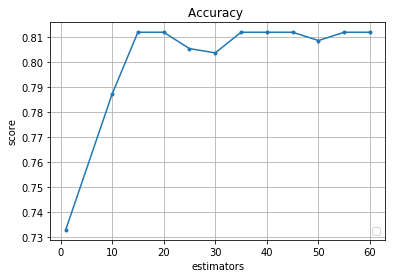

In [148]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.')
pylab.grid(True)
pylab.xlabel('estimators')
pylab.ylabel('score')
pylab.title('Accuracy ')
pylab.legend(loc='lower right')

<h3>XGBClassifier </h3>
<br>
Though we decided to use Random Forest as classifier, let's try and see how XGBClassifier will work 

In [162]:
estimator=xgb.XGBClassifier()
xgb_est=estimator.fit(x_scaled,y)

Fitting RandomizedSearchCV to find the best parameters

In [166]:
xgb_param = {
        'min_child_weight': [1, 3, 21],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.3, 0.8, 1.0],
        'learning_rate':[0.001, 0.1, 0.005],
        'max_depth': [3, 4, 5]
        }

In [167]:
rscv = RandomizedSearchCV(xgb_est ,param_distributions=xgb_param ,  cv =5 , n_iter=10 , scoring = 'accuracy',n_jobs =-1 , verbose =10)
rscv.fit(x,y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0 
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0 
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0 
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0, score=0.6885245901639344, total=   0.2s
[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0, score=0.6859504132231405, total=   0.2s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3 
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0, score=0.6885245901639344, total=   0.2s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0, score=0.6859504132231405, total=   0.2s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3, score=0.6885245901639344, total=   0.1s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3, score=0.6859504132231405, total=   0.1s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3, score=0.6885245901639344, total=   0.1s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3 
[CV] min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=1.0, score=0.6916666666666667, total=   0.3s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3, score=0.6859504132231405, total=   0.1s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.1, gamma=5, colsample_bytree=0.3, score=0.6916666666666667, total=   0.1s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3, score=0.6885245901639344, total=   0.1s


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


[CV] min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3, score=0.6885245901639344, total=   0.1s
[CV] min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3, score=0.6859504132231405, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3, score=0.6859504132231405, total=   0.1s
[CV] min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 
[CV] min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.005, gamma=0.5, colsample_bytree=0.3, score=0.6916666666666667, total=   0.2s
[CV] min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6885245901639344, total=   0.2s
[CV] min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6885245901639344, total=   0.1s
[CV] min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6859504132231405, total=   0.2s
[CV] min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6859504132231405, total=   0.2s
[CV] min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0 


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6916666666666667, total=   0.3s
[CV] min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

[CV]  min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0, score=0.7868852459016393, total=   0.3s
[CV]  min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0, score=0.8114754098360656, total=   0.3s
[CV] min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0 
[CV] min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0, score=0.7768595041322314, total=   0.4s
[CV] min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0, score=0.8512396694214877, total=   0.2s
[CV] min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=3, max_depth=3, learning_rate=0.001, gamma=2, colsample_bytree=1.0, score=0.8333333333333334, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV] min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8, score=0.8114754098360656, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV] min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8, score=0.7868852459016393, total=   0.2s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8, score=0.7768595041322314, total=   0.2s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

[CV]  min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8, score=0.8512396694214877, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6885245901639344, total=   0.2s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 
[CV]  min_child_weight=3, max_depth=4, learning_rate=0.001, gamma=2, colsample_bytree=0.8, score=0.8333333333333334, total=   0.2s
[CV] min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6885245901639344, total=   0.2s
[CV] min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6859504132231405, total=   0.1s
[CV] min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6859504132231405, total=   0.2s
[CV]  min_child_weight=21, max_depth=4, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.6916666666666667, total=   0.2s
[CV] min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0 
[CV] min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.6885245901639344, total=   0.2s
[CV] min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s
/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.6885245901639344, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV] min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8 
[CV]  min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.6859504132231405, total=   0.2s
[CV] min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.6859504132231405, total=   0.2s
[CV] min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=5, learning_rate=0.001, gamma=1, colsample_bytree=1.0, score=0.6916666666666667, total=   0.2s
[CV] min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8, score=0.6885245901639344, total=   0.1s
[CV] min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8, score=0.6885245901639344, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV] min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8, score=0.6859504132231405, total=   0.2s
[CV] min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8, score=0.6859504132231405, total=   0.2s
[CV] min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=21, max_depth=3, learning_rate=0.005, gamma=0.5, colsample_bytree=0.8, score=0.6916666666666667, total=   0.2s
[CV] min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8 


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8, score=0.7950819672131147, total=   0.2s
[CV] min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8, score=0.7704918032786885, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8, score=0.7768595041322314, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8, score=0.8512396694214877, total=   0.2s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=2, colsample_bytree=0.8, score=0.825, total=   0.2s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.7s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 3, 21], 'gamma': [0.5, 1, 1.5, 2, 5], 'colsample_bytree': [0.3, 0.8, 1.0], 'learning_rate': [0.001, 0.1, 0.005], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=10)

In [171]:
print(rscv.best_score_)
print(rscv.best_estimator_)
print(rscv.best_index_)
print(rscv.best_params_)

0.8118811881188119
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1.0, gamma=2,
       learning_rate=0.001, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
4
{'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.001, 'gamma': 2, 'colsample_bytree': 1.0}


In [172]:
estimator = xgb.XGBClassifier(n_estimators=5, min_child_weight =3, max_depth=3, learning_rate=0.001,colsample_bytree=1.0)
score = model_selection.cross_val_score(estimator, x_scaled, y, 
                                             scoring = 'accuracy', cv = 10) 

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

In [173]:
score.mean()

0.8054015004167823

In [174]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate=0.9, max_depth=10, booster='dart', n_estimators=n_tree, min_child_weight=5)
    score = model_selection.cross_val_score(estimator, x_scaled, y, 
                                             scoring = 'accuracy', cv = 10)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is amb

CPU times: user 5.94 s, sys: 108 ms, total: 6.05 s
Wall time: 6.55 s


/Users/olegmonahov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



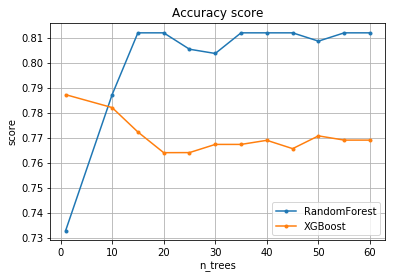

In [175]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [2107]:
x.shape

(305, 9)

ESTIMATOR IS HERE

In [178]:
estimator_final=ensemble.RandomForestClassifier(n_estimators = 40, min_samples_split=15,
                                                criterion='entropy',max_depth=5, min_samples_leaf=23, warm_start=False)
estimator_final.fit(x_scaled,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=23, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<h2>Transforming test data set </h2>
We'll need to do the same manipulations (fitting category data, dealing with missing values) for test data set as we did for train dataset

In [211]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [238]:
obj_df_test = df_test.select_dtypes(include=['object']).copy()


In [239]:
obj_df_test = obj_df_test.fillna({"Self_Employed": "No"})


In [240]:
obj_df_test['Gender'].value_counts()


Male      286
Female     70
Name: Gender, dtype: int64

In [241]:
obj_df_test['Gender'].value_counts()
obj_df_test = obj_df_test.fillna({"Gender": "Male"})


In [242]:
obj_df_test['Dependents'].value_counts()
obj_df_test = obj_df_test.fillna({"Dependents": "0"})


In [243]:
obj_df_test['Self_Employed'].value_counts()


No     330
Yes     37
Name: Self_Employed, dtype: int64

In [244]:
obj_df_test = obj_df_test.fillna({"Self_Employed": "No"})


In [245]:
obj_df_test[obj_df_test.isnull().any(axis=1)]


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area


In [246]:

obj_df_test["Gender"] = obj_df_test["Gender"].astype('category')

obj_df_test["Gender"] = obj_df_test["Gender"].cat.codes
obj_df_test["Married"] = obj_df_test["Married"].astype('category')

obj_df_test["Married"] = obj_df_test["Married"].cat.codes
obj_df_test["Dependents"] = obj_df_test["Dependents"].astype('category')

obj_df_test["Dependents"] = obj_df_test["Dependents"].cat.codes
obj_df_test["Education"] = obj_df_test["Education"].astype('category')

obj_df_test["Education"] = obj_df_test["Education"].cat.codes
obj_df_test["Self_Employed"] = obj_df_test["Self_Employed"].astype('category')

obj_df_test["Self_Employed"] = obj_df_test["Self_Employed"].cat.codes
obj_df_test["Property_Area"] = obj_df_test["Property_Area"].astype('category')

obj_df_test["Property_Area"] = obj_df_test["Property_Area"].cat.codes


In [247]:
obj_df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,LP001015,1,1,0,0,0,2
1,LP001022,1,1,1,0,0,2
2,LP001031,1,1,2,0,0,2
3,LP001035,1,1,2,0,0,2
4,LP001051,1,0,0,1,0,2


In [248]:
obj_df_test.shape

(367, 7)

In [249]:
int_df_test = df_test.select_dtypes(include=['int','float64']).copy()


int_df_test = int_df_test.fillna({"LoanAmount": np.mean(int_df_test['LoanAmount'])})

int_df_test = int_df_test.fillna({"Loan_Amount_Term": np.mean(int_df_test['Loan_Amount_Term'])})

int_df_test = int_df_test.fillna({"Credit_History": 1})


In [250]:
int_df_test[int_df.isnull().any(axis=1)]


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History


In [251]:
result_test = pd.concat([int_df_test, obj_df_test], axis=1, join='inner')

In [252]:
result_test[result_test.isnull().any(axis=1)]


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area


In [253]:
result_test.shape

(367, 12)

In [254]:
result_test.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,5720,0,110.0,360.0,1.0,LP001015,1,1,0,0,0,2
1,3076,1500,126.0,360.0,1.0,LP001022,1,1,1,0,0,2
2,5000,1800,208.0,360.0,1.0,LP001031,1,1,2,0,0,2
3,2340,2546,100.0,360.0,1.0,LP001035,1,1,2,0,0,2
4,3276,0,78.0,360.0,1.0,LP001051,1,0,0,1,0,2


In [315]:
X=result_test[['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term',
        'Credit_History', 'Gender', 'Married',
       'Dependents', 'Education', 'Self_Employed', 'Property_Area']]




In [317]:
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)


In [327]:
y_predict=estimator_final.predict(x_scaled)

In [328]:
predict_df=pd.DataFrame(y_predict)

Preparing resulting data frame for the output acceptable by competition

In [329]:
res=pd.concat([df_test['Loan_ID'], predict_df], axis=1, join='inner')

In [331]:
res.columns=['Loan_ID','Loan_Status']

In [344]:
res.columns=['Loan_ID','Loan_Status']
res['new_statys']=res['Loan_Status'].replace({1: "Y"})

In [345]:
res.columns=['Loan_ID','Loan_Status','new_statys']
# res['new_statys']=res['Loan_Status'].replace({0: "N"})
res['new_statys']=res['Loan_Status'].replace({0: "N", 1: "Y"})
res=res[['Loan_ID','new_statys']]

In [346]:
res.columns=['Loan_ID','Loan_Status']
res['new_statys']=res['Loan_Status'].replace({1: "Y"})
res['new_statys']=res['Loan_Status'].replace({0: "N", 1: "Y"})
res=res[['Loan_ID','new_statys']]
res.columns=['Loan_ID','Loan_Status']

In [348]:
res.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [349]:
res.to_csv('submission_for_loan_competition_xgb12.csv',index=False)